In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import seaborn as sns
from PIL import Image
import math

In [2]:
cd './cycles/sim_data'

/Users/weinan/Documents/GitHub/oTreeProjects/TimingGames2024/cycles/sim_data


In [3]:

## avg cycle length
def calculate_avg_cycle_length(cycle_start_round_number):
    individual_cycle_length = [y - x for x,y in zip(cycle_start_round_number,cycle_start_round_number[1:])]
    cycle_length_array = np.array(individual_cycle_length)
    avg_cycle_length = cycle_length_array.mean()
    return avg_cycle_length


# NE payoff
def calculate_NE_payoff(data):
    if data['game_type'] == 'fear':
        theory_payoff = (1+1/data['rho'])*(1-1/data['gamma'])*(1+data['lambda']**2)
    elif data['game_type'] == 'greed':
        theory_payoff = 1+data['lambda']**2
    return theory_payoff

# avg payoff in a cycle
def calculate_cycle_payoff(data):
    avg_cycle_payoff = []
    cycle_start_round_number = data['cycle_start_round_number']
    for cycle_index in range(len(cycle_start_round_number)-1):
        cycle_payoff_each_period = 0
        for i in range(cycle_start_round_number[cycle_index], cycle_start_round_number[cycle_index+1]):
            data['bubble', i] = np.array(data['bubble', i])
            cycle_payoff_each_period += data['bubble', i].mean()
        avg_cycle_payoff.append(cycle_payoff_each_period/(cycle_start_round_number[cycle_index+1] - cycle_start_round_number[cycle_index]))
    avg_cycle_payoff = np.array(avg_cycle_payoff)
    avg_cycle_payoff = avg_cycle_payoff.mean()
    return avg_cycle_payoff

# cycle edge location
def calculate_cycle_edge_location(data):
    edge_location = []
    cycle_start_round_number = data['cycle_start_round_number']
    for cycle_index in range(1,len(cycle_start_round_number)-1):
        period_before_jump =  cycle_start_round_number[cycle_index] - 1
        # find the lowest location one period before jumpping in fear and highest location in greed
        if data['game_type'] == 'fear':
            edge_location.append(data['strategies', period_before_jump].min())
        elif data['game_type'] == 'greed':
            edge_location.append(data['strategies', period_before_jump].max())
    edge_location = np.array(edge_location)
    edge_location = edge_location.mean()
    return edge_location

# cycle edge location
def calculate_cycle_tunnel_location(data):
    tunnel_location = []
    cycle_start_round_number = data['cycle_start_round_number']
    for cycle_index in range(1,len(cycle_start_round_number)-1):
        period_tunnel =  cycle_start_round_number[cycle_index]+1
        # find tunnel location at the beginning of cycle
        if data['game_type'] == 'fear':
            tunnel_location.append(data['strategies', period_tunnel].max())
        elif data['game_type'] == 'greed':
            tunnel_location.append(data['strategies', period_tunnel].min())
    tunnel_location = np.array(tunnel_location)
    tunnel_location = tunnel_location.mean()
    return tunnel_location

# theoretical rush location
def calculate_theoretical_rush_location(data):
    if data['game_type'] == 'fear':
        theory_rush_location = max(0, round((data['lambda'] - math.sqrt(1+data['lambda']**2) * math.sqrt(1-(16*(1+data['rho'])*(data['gamma']-1))/((data['gamma'] +3*data['rho'])*(3*data['gamma'] +data['rho'])))),2))
    elif data['game_type'] == 'greed':
        theory_rush_location = round(data['lambda'] + math.sqrt(1+data['lambda']**2)/(math.sqrt(1+16*data['rho']*data['gamma']/((3*data['gamma']-3*data['rho']-2)*(data['gamma']-data['rho']+2)))), 2)
    return theory_rush_location    

def generate_row(pickle_file):
    with open(pickle_file, 'rb') as f:
    # Load the data from the file
        data = pickle.load(f)
    # basic info
    game_type = data['game_type']
    num_bots = data['num_bots']
    lam = data['lambda']
    gam = data['gamma']
    rho = data['rho']
    move_percent = data['move_percent']
    trembling_dist = data['trembling_dist']
    trembling_range = data['trembling_range'][-1]
    leaving_function = data['leaving_function']

    # cycle info
    if_atom =  data['if_atom']
    if_slow_cycle =  data['if_slow_cycle']
    if if_atom==1:
        avg_cycle_length = -1
        avg_cycle_payoff = np.nan
        NE_payoff = calculate_NE_payoff(data)
        edge_location = np.nan
        theory_rush_location = calculate_theoretical_rush_location(data)
        tunnel_location = calculate_cycle_tunnel_location(data)        
    elif if_slow_cycle == 1:
        avg_cycle_length = 10000
        avg_cycle_payoff = np.nan
        NE_payoff = calculate_NE_payoff(data)
        edge_location = np.nan
        theory_rush_location = calculate_theoretical_rush_location(data)
        tunnel_location = calculate_cycle_tunnel_location(data)
    else:
        cycle_start_round_number = data['cycle_start_round_number']
        avg_cycle_length = calculate_avg_cycle_length(cycle_start_round_number)
        avg_cycle_payoff = calculate_cycle_payoff(data)
        NE_payoff = calculate_NE_payoff(data)
        edge_location = calculate_cycle_edge_location(data)
        theory_rush_location = calculate_theoretical_rush_location(data)
        tunnel_location = calculate_cycle_tunnel_location(data)
        
    return [game_type,num_bots,lam,gam,rho,gam-rho,move_percent,trembling_dist,trembling_range,
            leaving_function,avg_cycle_length, avg_cycle_payoff, NE_payoff, edge_location, theory_rush_location, tunnel_location]




In [16]:
##greed with rush
main_folder = './greed_20_4.4_3_by_noise/'
file_name = 'greed_lgr_20_4.4_3_bots20_move0.2_leaving_random_trembling_normal'
noise_values = np.arange(0.0,0.31, 0.01)
gam_value=[4.4]
rho_value=[3]

df_rows = []
    
for noise_value in noise_values:
    noise_value = round(noise_value,2)
    pickle_file = main_folder+ file_name+ str(noise_value) +'.pickle'
    df_rows.append(generate_row(pickle_file))

df_greed_with_rush = pd.DataFrame(df_rows, columns=['game_type', 'num_bots', 'lam', 'gam', 'rho','gam_minus_rho', 'move_percent', 'trembling_dist', 
                               'trembling_range', 'leaving_function', 'avg_cycle_length', 'avg_cycle_payoff', 'NE_payoff', 
                                    'edge_location', 'theory_rush_location', 'tunnel_location'])

##greed without rush
main_folder = './greed_20_9_3_by_noise/'
file_name = 'greed_lgr_20_9_3_bots20_move0.2_leaving_random_trembling_normal'
noise_values = np.arange(0.0,0.31, 0.01)
gam_value=[9]
rho_value=[3]

df_rows = []
    
for noise_value in noise_values:
    noise_value = round(noise_value,2)
    pickle_file = main_folder+ file_name+ str(noise_value) +'.pickle'
    df_rows.append(generate_row(pickle_file))

df_greed_without_rush = pd.DataFrame(df_rows, columns=['game_type', 'num_bots', 'lam', 'gam', 'rho','gam_minus_rho', 'move_percent', 'trembling_dist', 
                               'trembling_range', 'leaving_function', 'avg_cycle_length', 'avg_cycle_payoff', 'NE_payoff', 
                                    'edge_location', 'theory_rush_location', 'tunnel_location'])

##fear with rush
main_folder = './fear_20_3.6_3_by_noise/'
file_name = 'fear_lgr_20_3.6_3_bots20_move0.2_leaving_random_trembling_normal'
noise_values = np.arange(0.0,0.31, 0.01)
gam_value=[3.6]
rho_value=[3]

df_rows = []
    
for noise_value in noise_values:
    noise_value = round(noise_value,2)
    pickle_file = main_folder+ file_name+ str(noise_value) +'.pickle'
    df_rows.append(generate_row(pickle_file))

df_fear_with_rush = pd.DataFrame(df_rows, columns=['game_type', 'num_bots', 'lam', 'gam', 'rho','gam_minus_rho', 'move_percent', 'trembling_dist', 
                               'trembling_range', 'leaving_function', 'avg_cycle_length', 'avg_cycle_payoff', 'NE_payoff', 
                                    'edge_location', 'theory_rush_location', 'tunnel_location'])

##fear without rush
main_folder = './fear_20_3_3_by_noise/'
file_name = 'fear_lgr_20_3_3_bots20_move0.2_leaving_random_trembling_normal'
noise_values = np.arange(0.0,0.31, 0.01)
gam_value=[3]
rho_value=[3]

df_rows = []
    
for noise_value in noise_values:
    noise_value = round(noise_value,2)
    pickle_file = main_folder+ file_name+ str(noise_value) +'.pickle'
    df_rows.append(generate_row(pickle_file))

df_fear_without_rush = pd.DataFrame(df_rows, columns=['game_type', 'num_bots', 'lam', 'gam', 'rho','gam_minus_rho', 'move_percent', 'trembling_dist', 
                               'trembling_range', 'leaving_function', 'avg_cycle_length', 'avg_cycle_payoff', 'NE_payoff', 
                                    'edge_location', 'theory_rush_location', 'tunnel_location'])


<IPython.core.display.Javascript object>


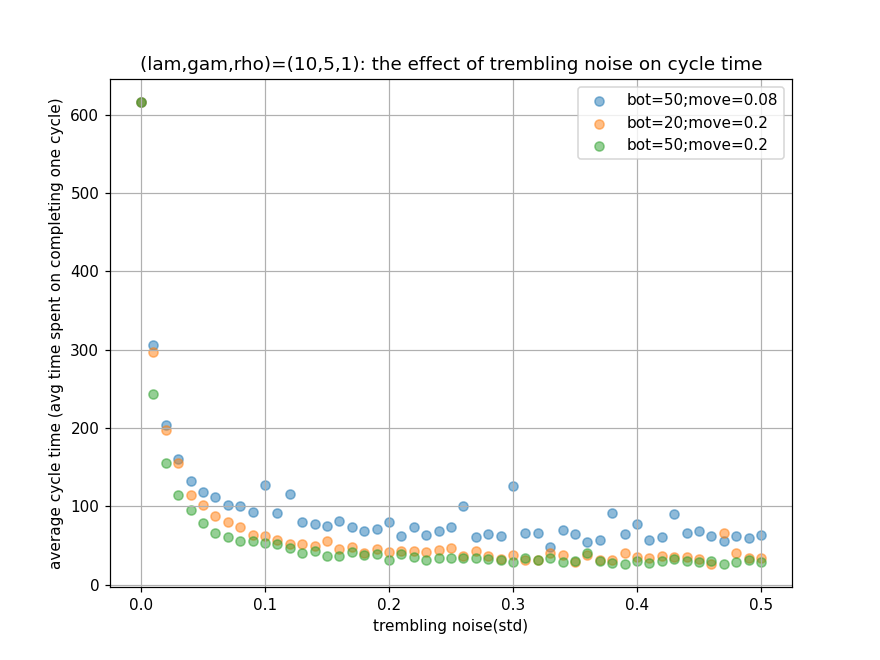

In [12]:
%matplotlib notebook
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_greed_bot50_move8['trembling_range'], df_greed_bot50_move8['avg_cycle_length'], label='bot=50;move=0.08', alpha=0.5)
plt.scatter(df_greed_move20['trembling_range'], df_greed_move20['avg_cycle_length'], label='bot=20;move=0.2', alpha=0.5)
plt.scatter(df_greed_bot50_move20['trembling_range'], df_greed_bot50_move20['avg_cycle_length'], label='bot=50;move=0.2', alpha=0.5)

# plt.scatter(df_greed_long_length['trembling_range'], df_greed_long_length['avg_cycle_length'], label='long NE', alpha=0.5)
# plt.scatter(df_greed_long_cycle['trembling_range'], df_greed_long_cycle['avg_cycle_length'], label='long cycle', alpha=0.5)
plt.title('(lam,gam,rho)=(10,5,1): the effect of trembling noise on cycle time')
plt.ylabel('average cycle time (avg time spent on completing one cycle)')
plt.xlabel('trembling noise(std)')
# plt.ylim([0,1000])
plt.grid()
plt.legend()
plt.show()
plt.savefig('cycle_length_by_noise_bot_move.png', bbox_inches='tight')

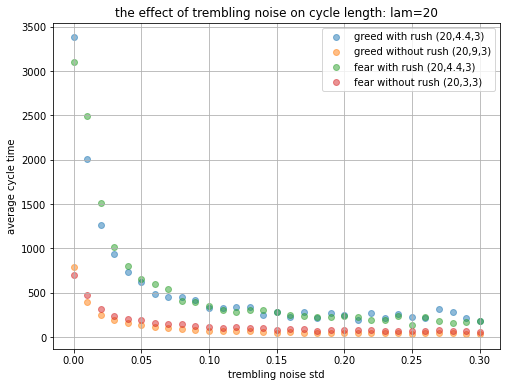

In [17]:
%matplotlib inline
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_greed_with_rush['trembling_range'], df_greed_with_rush['avg_cycle_length'], label='greed with rush (20,4.4,3)', alpha=0.5)
plt.scatter(df_greed_without_rush['trembling_range'], df_greed_without_rush['avg_cycle_length'], label='greed without rush (20,9,3)', alpha=0.5)
plt.scatter(df_fear_with_rush['trembling_range'], df_fear_with_rush['avg_cycle_length'], label='fear with rush (20,4.4,3)', alpha=0.5)
plt.scatter(df_fear_without_rush['trembling_range'], df_fear_without_rush['avg_cycle_length'], label='fear without rush (20,3,3)', alpha=0.5)
# plt.scatter(df_greed_with_rush['trembling_range'], df_greed_with_rush['avg_cycle_length'], label='greed with rush (10,2,0.5)', alpha=0.5)
# plt.scatter(df_greed_without_rush['trembling_range'], df_greed_without_rush['avg_cycle_length'], label='greed without rush (10,5,1)', alpha=0.5)
# plt.scatter(df_fear_with_rush['trembling_range'], df_fear_with_rush['avg_cycle_length'], label='fear with rush (10,1.5,1)', alpha=0.5)
# plt.scatter(df_fear_without_rush['trembling_range'], df_fear_without_rush['avg_cycle_length'], label='fear without rush (10,2,4)', alpha=0.5)

plt.title('the effect of trembling noise on cycle length: lam=20')
plt.ylabel('average cycle time')
plt.xlabel('trembling noise std')
# plt.ylim([0,1000])
plt.grid()
plt.legend()
plt.savefig('cycle_length_by_noise_lam20.png', bbox_inches='tight')
plt.show()


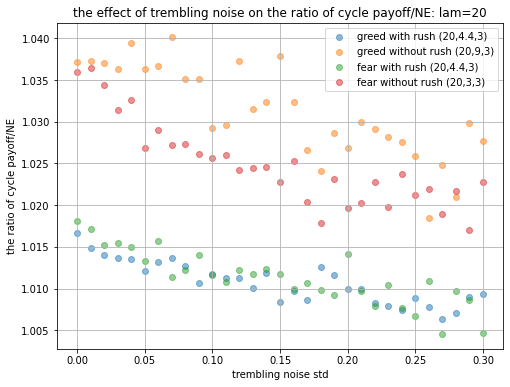

In [18]:
%matplotlib inline
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_greed_with_rush['trembling_range'], df_greed_with_rush['avg_cycle_payoff']/df_greed_with_rush['NE_payoff'], label='greed with rush (20,4.4,3)', alpha=0.5)
plt.scatter(df_greed_without_rush['trembling_range'], df_greed_without_rush['avg_cycle_payoff']/df_greed_without_rush['NE_payoff'], label='greed without rush (20,9,3)', alpha=0.5)
plt.scatter(df_fear_with_rush['trembling_range'], df_fear_with_rush['avg_cycle_payoff']/df_fear_with_rush['NE_payoff'], label='fear with rush (20,4.4,3)', alpha=0.5)
plt.scatter(df_fear_without_rush['trembling_range'], df_fear_without_rush['avg_cycle_payoff']/df_fear_without_rush['NE_payoff'], label='fear without rush (20,3,3)', alpha=0.5)
# plt.scatter(df_greed_with_rush['trembling_range'], df_greed_with_rush['avg_cycle_length'], label='greed with rush (10,2,0.5)', alpha=0.5)
# plt.scatter(df_greed_without_rush['trembling_range'], df_greed_without_rush['avg_cycle_length'], label='greed without rush (10,5,1)', alpha=0.5)
# plt.scatter(df_fear_with_rush['trembling_range'], df_fear_with_rush['avg_cycle_length'], label='fear with rush (10,1.5,1)', alpha=0.5)
# plt.scatter(df_fear_without_rush['trembling_range'], df_fear_without_rush['avg_cycle_length'], label='fear without rush (10,2,4)', alpha=0.5)

plt.title('the effect of trembling noise on the ratio of cycle payoff/NE: lam=20')
plt.ylabel('the ratio of cycle payoff/NE')
plt.xlabel('trembling noise std')
# plt.ylim([0,1000])
plt.grid()
plt.legend()
plt.savefig('payoff_ratio_by_noise_lam20.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


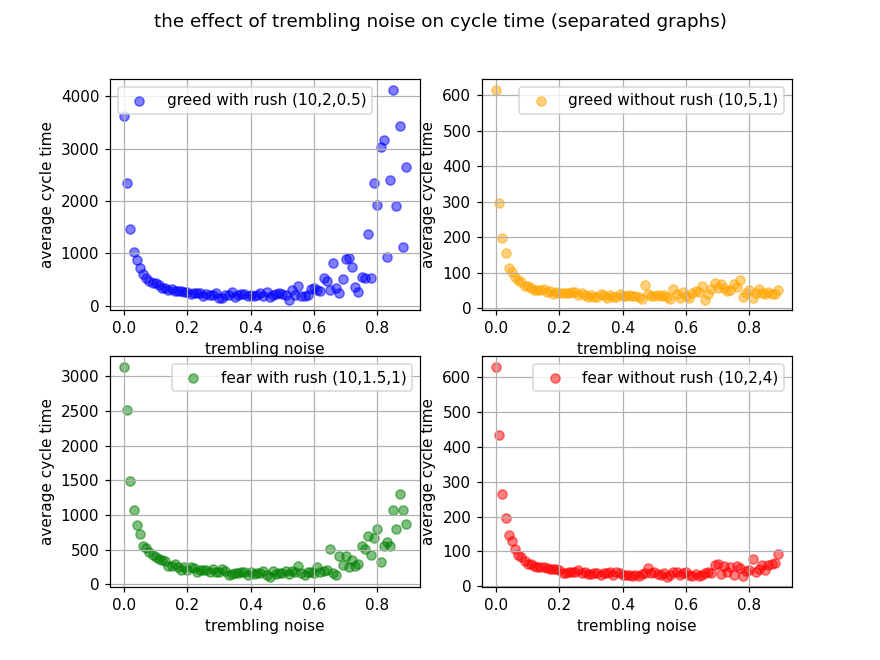

Text(0.5, 0.98, 'the effect of trembling noise on cycle time (separated graphs)')

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs[0, 0].scatter(df_greed_with_rush['trembling_range'], df_greed_with_rush['avg_cycle_length'], label='greed with rush (10,2,0.5)', alpha=0.5, color='b')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 0].set_xlabel('trembling noise std')
axs[0, 0].set_ylabel('average cycle time')
# axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].scatter(df_greed_without_rush['trembling_range'], df_greed_without_rush['avg_cycle_length'], label='greed without rush (10,5,1)', alpha=0.5, color='orange')
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].set_xlabel('trembling noise std')
axs[0, 1].set_ylabel('average cycle time')
# axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].scatter(df_fear_with_rush['trembling_range'], df_fear_with_rush['avg_cycle_length'], label='fear with rush (10,1.5,1)', alpha=0.5, color='g')
axs[1, 0].legend()
axs[1, 0].grid()
axs[1, 0].set_xlabel('trembling noise std')
axs[1, 0].set_ylabel('average cycle time')
# axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].scatter(df_fear_without_rush['trembling_range'], df_fear_without_rush['avg_cycle_length'], label='fear without rush (10,2,4)', alpha=0.5, color='r')
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].set_xlabel('trembling noise std')
axs[1, 1].set_ylabel('average cycle time')
# axs[1, 1].set_title('Axis [1, 1]')
plt.legend()
plt.show()
plt.suptitle('the effect of trembling noise on cycle time (separated graphs)')
# plt.savefig(main_folder+'cycle_length_by_noise_separate.png', bbox_inches='tight')

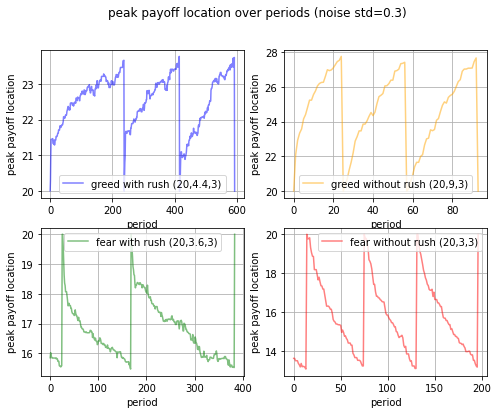

In [21]:
# plot best payoff location over periods
noise_value = 0.3
##greed with rush
main_folder = './greed_20_4.4_3_by_noise/'
file_name = 'greed_lgr_20_4.4_3_bots20_move0.2_leaving_random_trembling_normal'
gam_value=[4.4]
rho_value=[3]
pickle_file_greed_with_rush = main_folder+ file_name+ str(noise_value) +'.pickle'
with open(pickle_file_greed_with_rush, 'rb') as f:
# Load the data from the file
    pickle_file_greed_with_rush = pickle.load(f)

##greed without rush
main_folder = './greed_20_9_3_by_noise/'
file_name = 'greed_lgr_20_9_3_bots20_move0.2_leaving_random_trembling_normal'
gam_value=[9]
rho_value=[3]
pickle_file_greed_without_rush = main_folder+ file_name+ str(noise_value) +'.pickle'
with open(pickle_file_greed_without_rush, 'rb') as f:
# Load the data from the file
    pickle_file_greed_without_rush = pickle.load(f)

##fear with rush
main_folder = './fear_20_3.6_3_by_noise/'
file_name = 'fear_lgr_20_3.6_3_bots20_move0.2_leaving_random_trembling_normal'
gam_value=[3.6]
rho_value=[3]
pickle_file_fear_with_rush = main_folder+ file_name+ str(noise_value) +'.pickle'
with open(pickle_file_fear_with_rush, 'rb') as f:
# Load the data from the file
    pickle_file_fear_with_rush = pickle.load(f)
    
##fear without rush
main_folder = './fear_20_3_3_by_noise/'
file_name = 'fear_lgr_20_3_3_bots20_move0.2_leaving_random_trembling_normal'
gam_value=[3]
rho_value=[3]
pickle_file_fear_without_rush = main_folder+ file_name+ str(noise_value) +'.pickle'
with open(pickle_file_fear_without_rush, 'rb') as f:
# Load the data from the file
    pickle_file_fear_without_rush = pickle.load(f)

fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs[0, 0].plot(pickle_file_greed_with_rush['history_round'], pickle_file_greed_with_rush['history_peak_payoff_location'], label='greed with rush (20,4.4,3)', alpha=0.5, color='b')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 0].set_xlabel('period')
axs[0, 0].set_ylabel('peak payoff location')
# axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(pickle_file_greed_without_rush['history_round'], pickle_file_greed_without_rush['history_peak_payoff_location'], label='greed without rush (20,9,3)', alpha=0.5, color='orange')
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].set_xlabel('period')
axs[0, 1].set_ylabel('peak payoff location')
# axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(pickle_file_fear_with_rush['history_round'], pickle_file_fear_with_rush['history_peak_payoff_location'], label='fear with rush (20,3.6,3)', alpha=0.5, color='g')
axs[1, 0].legend()
axs[1, 0].grid()
axs[1, 0].set_xlabel('period')
axs[1, 0].set_ylabel('peak payoff location')
# axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(pickle_file_fear_without_rush['history_round'], pickle_file_fear_without_rush['history_peak_payoff_location'], label='fear without rush (20,3,3)', alpha=0.5, color='r')
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].set_xlabel('period')
axs[1, 1].set_ylabel('peak payoff location')
# axs[1, 1].set_title('Axis [1, 1]')
plt.legend()

plt.suptitle('peak payoff location over periods (noise std=' +str(noise_value)+')')
plt.savefig('peak_payoff_location_noise'+str(noise_value)+'_lam20.png', bbox_inches='tight')
plt.show()

In [5]:
# main_folder = './fear_data/leaving_random_trembling_none/'
main_folder = './fear_data_lam10_move80_noise0.05_zeta4/'
rest_file_name = '_bots20_move0.8_leaving_random_trembling_normal0.1'
leaving = 'random'
trembling_dist = 'normal'
trembling_range = 0.1
rho_values = [1,1.5, 2,2.5, 3,3.5, 4,4.5, 5, 6, 7, 8, 10, 20]
gam_minus_rho = np.array(
   [ -4, -3, -2, -1, 0, #fear w/o rush
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6 #fear w/ rush
    ]) #two eqm: fear

df_rows = []
    
for rho_value in rho_values:
    gam_values = rho_value + gam_minus_rho
    for gam_value in gam_values:
        if gam_value > 1:
            pickle_file = main_folder+'fear_lgr_20_'+ str(gam_value)+'_'+str(rho_value) + rest_file_name +'.pickle'
            df_rows.append(generate_row(pickle_file))
        else:
            df_rows.append(['fear', 20,20,gam_value,rho_value,gam_value-rho_value,0.8,trembling_dist,trembling_range,leaving,np.nan])

df = pd.DataFrame(df_rows, columns=['game_type', 'num_bots', 'lam', 'gam', 'rho','gam_minus_rho', 'move_percent', 'trembling_dist', 
                               'trembling_range', 'leaving_function', 'avg_cycle_length', 'avg_cycle_payoff', 'NE_payoff', 
                                    'edge_location', 'theory_rush_location', 'tunnel_location'])

lam = str(round(df.iloc[0]['lam']))
move = str(round(df.iloc[0]['move_percent'],1))
trembling = df.iloc[0]['trembling_dist'] + str(df.iloc[0]['trembling_range'])
df[10:20]

,game_type,num_bots,lam,gam,rho,gam_minus_rho,move_percent,trembling_dist,trembling_range,leaving_function,avg_cycle_length,avg_cycle_payoff,NE_payoff,edge_location,theory_rush_location,tunnel_location
10,fear,20,20,1.6,1.0,0.6,0.8,normal,0.1,random,243.5,344.689387,300.750000,8.40,9.40,20.19
11,fear,20,20,-2.5,1.5,-4.0,0.8,normal,0.1,random,NaN,NaN,NaN,NaN,NaN,NaN
12,fear,20,20,-1.5,1.5,-3.0,0.8,normal,0.1,random,NaN,NaN,NaN,NaN,NaN,NaN
13,fear,20,20,-0.5,1.5,-2.0,0.8,normal,0.1,random,NaN,NaN,NaN,NaN,NaN,NaN
14,fear,20,20,0.5,1.5,-1.0,0.8,normal,0.1,random,NaN,NaN,NaN,NaN,NaN,NaN
15,fear,20,20,1.5,1.5,0.0,0.8,normal,0.1,random,92.0,275.873029,222.777778,6.04,6.65,20.17
16,fear,20,20,1.6,1.5,0.1,0.8,normal,0.1,random,102.5,295.417376,250.625000,7.02,7.73,20.17
17,fear,20,20,1.7,1.5,0.2,0.8,normal,0.1,random,111.0,315.688549,275.196078,8.10,8.75,20.20
18,fear,20,20,1.8,1.5,0.3,0.8,normal,0.1,random,121.0,332.872292,297.037037,9.06,9.71,20.19
19,fear,20,20,1.9,1.5,0.4,0.8,normal,0.1,random,136.0,346.635459,316.578947,9.96,10.63,20.14


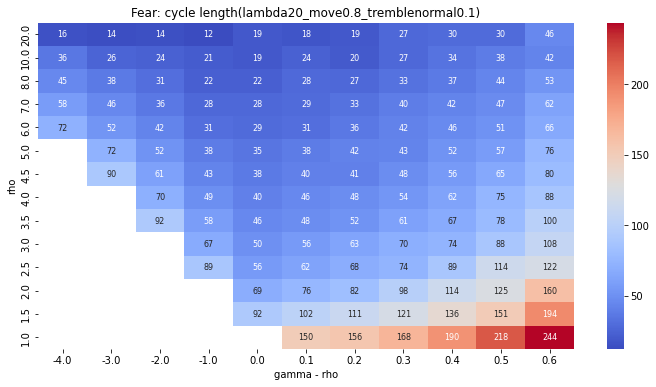

<Figure size 432x288 with 0 Axes>

In [7]:
%matplotlib inline
df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='avg_cycle_length', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".0f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: cycle length' + '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_cycle_length.png', bbox_inches='tight')

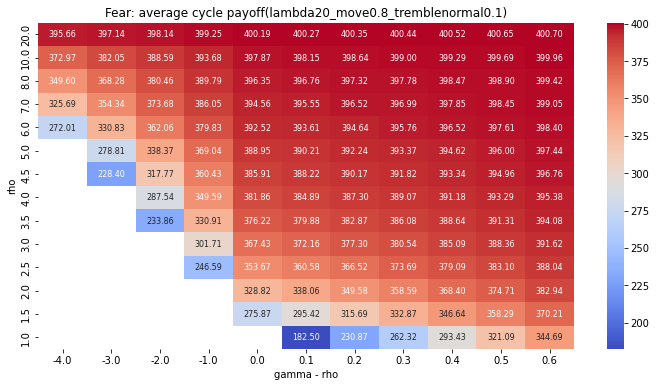

<Figure size 432x288 with 0 Axes>

In [8]:
## cycle payoff

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='avg_cycle_payoff', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: average cycle payoff'+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_cycle_payoff.png', bbox_inches='tight')

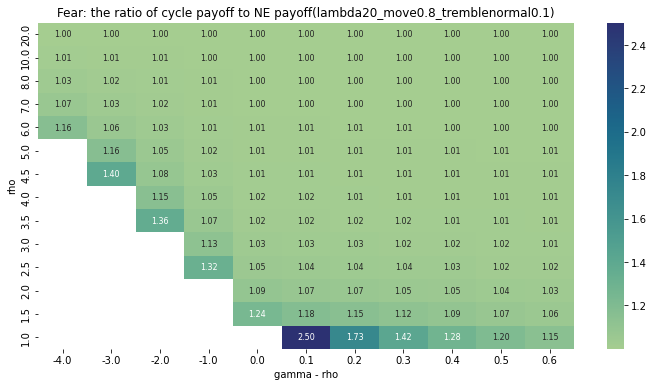

<Figure size 432x288 with 0 Axes>

In [9]:
## cycle payoff/NE payoff

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['cycle_by_NE'] = df_copy['avg_cycle_payoff']/df_copy['NE_payoff']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='cycle_by_NE', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: the ratio of cycle payoff to NE payoff'+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_cycle_payoff_by_NE.png', bbox_inches='tight')

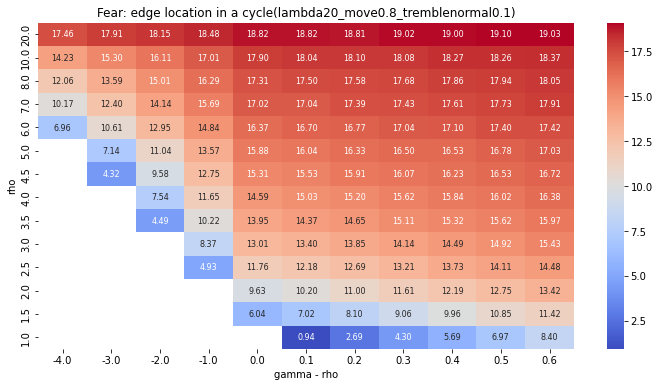

<Figure size 432x288 with 0 Axes>

In [10]:
## cycle edge location

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_location', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: edge location in a cycle'+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_edge_location.png', bbox_inches='tight')

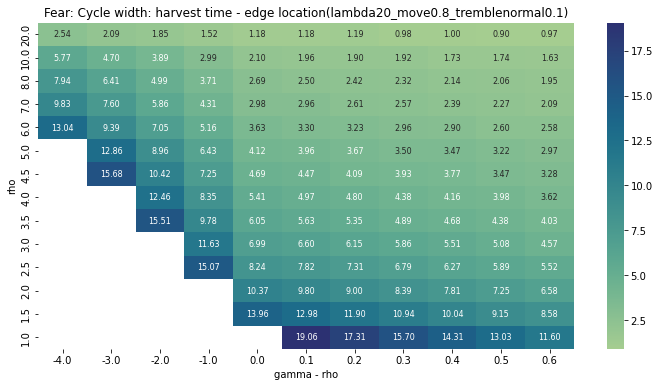

<Figure size 432x288 with 0 Axes>

In [11]:
## 10 - edge location (cycle interval)

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = int(lam) - df_copy['edge_location'] 
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_minus_rush', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: Cycle width: harvest time - edge location'+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_edge_minus_harvest.png', bbox_inches='tight')

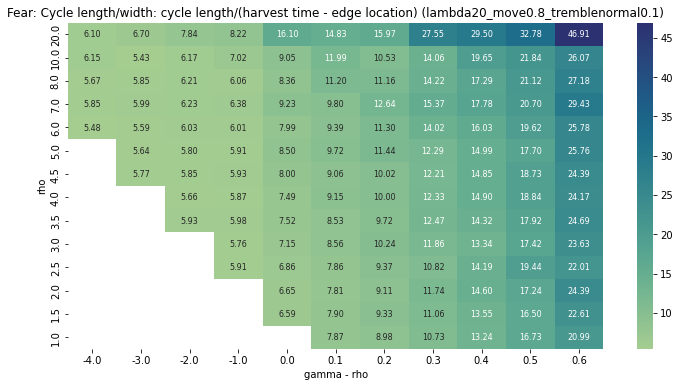

<Figure size 432x288 with 0 Axes>

In [12]:
## length/(10 - edge location) (cycle interval)

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = int(lam) - df_copy['edge_location'] 
df_copy['length_over_width'] = df_copy['avg_cycle_length']/df_copy['edge_minus_rush']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='length_over_width', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: Cycle length/width: cycle length/(harvest time - edge location) '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'length_over_width.png', bbox_inches='tight')

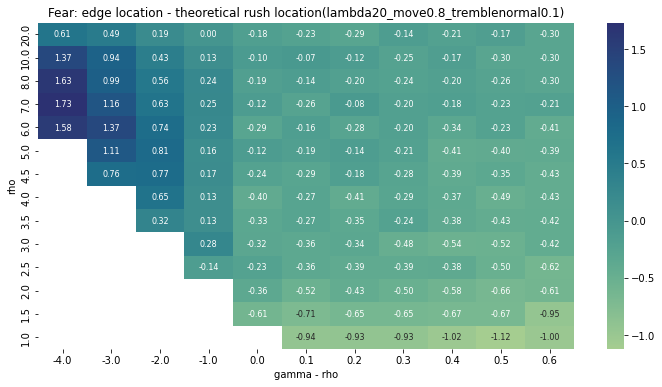

<Figure size 432x288 with 0 Axes>

In [13]:
## edge location - theory rush location

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = df_copy['edge_location'] - df_copy['theory_rush_location']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_minus_rush', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: edge location - theoretical rush location'+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_edge_minus_rush.png', bbox_inches='tight')

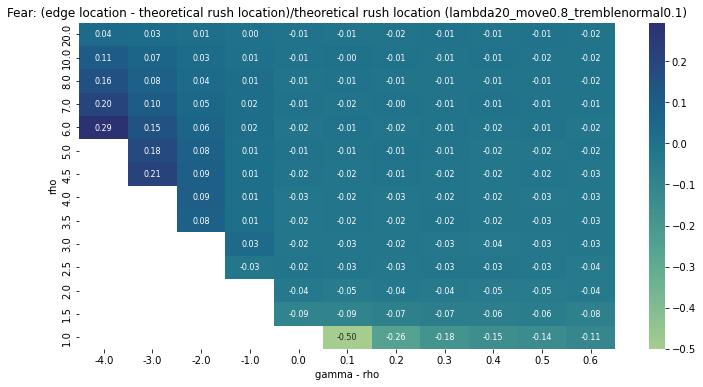

<Figure size 432x288 with 0 Axes>

In [14]:
## (edge location - theory rush location) / theory rush location

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = (df_copy['edge_location'] - df_copy['theory_rush_location'])/df_copy['theory_rush_location']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_minus_rush', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: (edge location - theoretical rush location)/theoretical rush location ' + '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_edge_minus_rush_percentage.png', bbox_inches='tight')

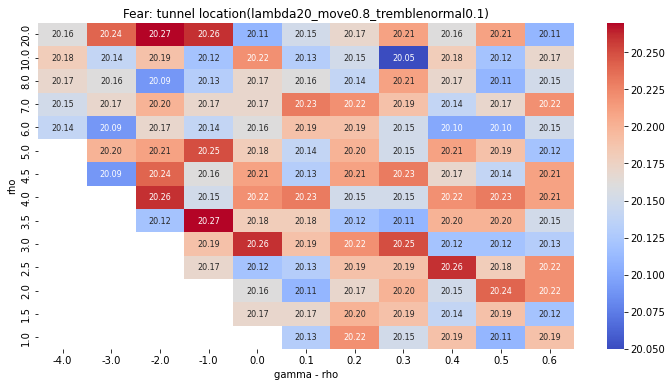

<Figure size 432x288 with 0 Axes>

In [15]:

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='tunnel_location', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Fear: tunnel location' + '(lambda' + lam + '_move'+move+'_tremble'+trembling+')')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
plt.savefig(main_folder+'fear_tunnel_location.png', bbox_inches='tight')

In [88]:
# main_folder = './greed_data/leaving_random_trembling_none/'
main_folder = './greed_data_lam10_move80_noise0.05_distance_most_gain/'
rest_file_name = '_bots20_move0.8_leaving_distance_most_gain_trembling_normal0.05'

rho_values = [0.5,1,1.5, 2,2.5, 3,3.5, 4,4.5, 5, 6, 7, 8, 10, 20]
gam_minus_rho = np.array(
   [  #two eqm: greed
    1.4, 1.5, 1.6, 1.7, 1.8, 1.9, #greed w/ rush
     2, 3, 4, 5, 6]) #greed w/o rush

df_rows = []
    
for rho_value in rho_values:
    gam_values = rho_value + gam_minus_rho
    for gam_value in gam_values:
        pickle_file =main_folder+ 'greed_lgr_10_'+ str(gam_value)+'_'+str(rho_value) +rest_file_name+'.pickle'
        df_rows.append(generate_row(pickle_file))
df = pd.DataFrame(df_rows, columns=['game_type', 'num_bots', 'lam', 'gam', 'rho','gam_minus_rho', 'move_percent', 'trembling_dist', 
                               'trembling_range', 'leaving_function', 'avg_cycle_length','avg_cycle_payoff', 'NE_payoff',
                                    'edge_location','theory_rush_location', 'tunnel_location'])

lam = str(round(df.iloc[0]['lam']))
move = str(round(df.iloc[0]['move_percent'],1))
trembling = df.iloc[0]['trembling_dist'] + str(df.iloc[0]['trembling_range'])
df[10:20]


,game_type,num_bots,lam,gam,rho,gam_minus_rho,move_percent,trembling_dist,trembling_range,leaving_function,avg_cycle_length,avg_cycle_payoff,NE_payoff,edge_location,theory_rush_location,tunnel_location
10,greed,20,10,6.5,0.5,6.0,0.8,normal,0.05,distance_most_gain,83.0,143.859415,101,17.78,18.47,9.88
11,greed,20,10,2.4,1.0,1.4,0.8,normal,0.05,distance_most_gain,188.0,109.226579,101,14.17,14.06,9.92
12,greed,20,10,2.5,1.0,1.5,0.8,normal,0.05,distance_most_gain,151.5,109.439045,101,14.34,14.26,9.91
13,greed,20,10,2.6,1.0,1.6,0.8,normal,0.05,distance_most_gain,125.0,110.036462,101,14.53,14.44,9.89
14,greed,20,10,2.7,1.0,1.7,0.8,normal,0.05,distance_most_gain,106.5,110.615412,101,14.65,14.60,9.91
15,greed,20,10,2.8,1.0,1.8,0.8,normal,0.05,distance_most_gain,89.0,110.953485,101,14.75,14.75,9.92
16,greed,20,10,2.9,1.0,1.9,0.8,normal,0.05,distance_most_gain,76.5,111.206713,101,14.89,14.89,9.93
17,greed,20,10,3.0,1.0,2.0,0.8,normal,0.05,distance_most_gain,69.5,111.316772,101,15.01,15.02,9.96
18,greed,20,10,4.0,1.0,3.0,0.8,normal,0.05,distance_most_gain,60.5,114.076022,101,15.72,15.98,9.94
19,greed,20,10,5.0,1.0,4.0,0.8,normal,0.05,distance_most_gain,66.0,117.011518,101,16.10,16.58,9.96


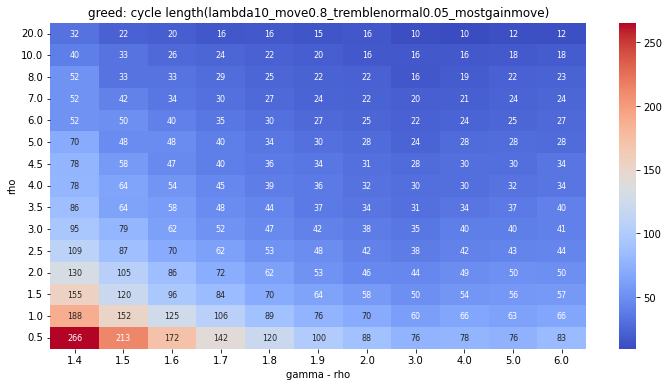

In [89]:

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='avg_cycle_length', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)


# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".0f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('greed: cycle length' + '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
# plt.show()
plt.savefig(main_folder+'greed_cycle_length.png', bbox_inches='tight')

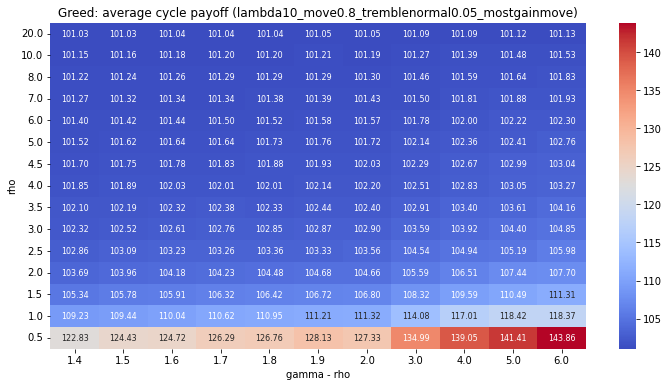

In [90]:
## cycle payoff

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='avg_cycle_payoff', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: average cycle payoff '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'greed_cycle_payoff.png', bbox_inches='tight')
plt.show()

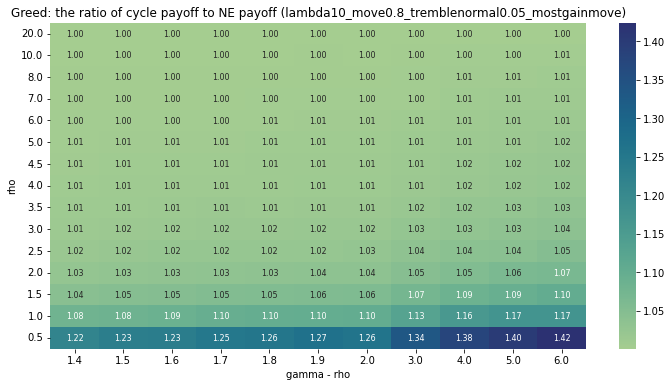

In [91]:
## cycle payoff/NE payoff

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['cycle_by_NE'] = df_copy['avg_cycle_payoff']/df_copy['NE_payoff']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='cycle_by_NE', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: the ratio of cycle payoff to NE payoff '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'greed_cycle_payoff_by_NE.png', bbox_inches='tight')
plt.show()

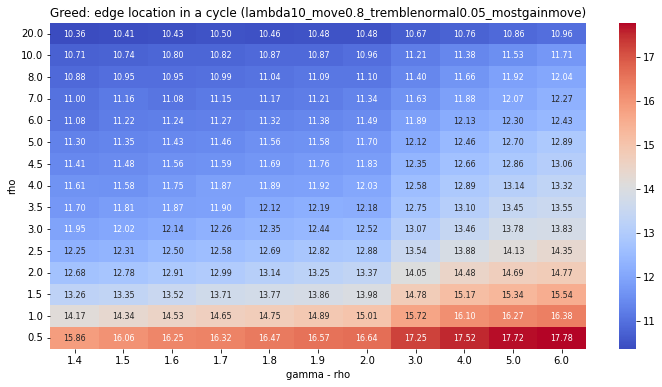

In [92]:
## cycle edge location

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_location', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: edge location in a cycle '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'greed_edge_location.png', bbox_inches='tight')
plt.show()

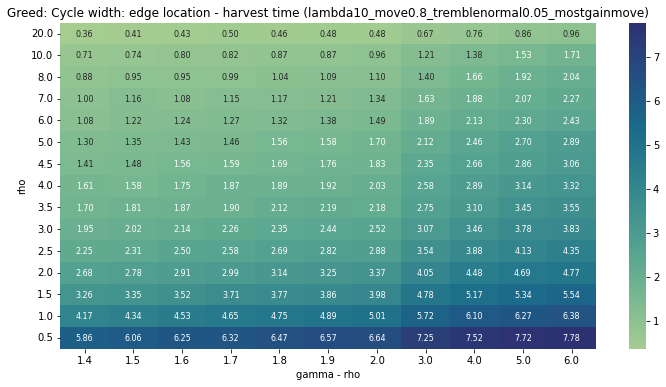

In [93]:
## edge location - 15 (cycle interval)

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = df_copy['edge_location'] - int(lam)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_minus_rush', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: Cycle width: edge location - harvest time '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'greed_edge_minus_harvest.png', bbox_inches='tight')
plt.show()

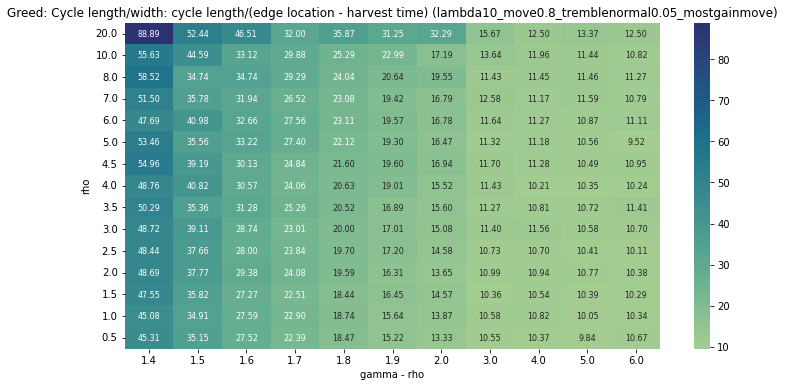

In [94]:
## lenth/(edge location - 15) (cycle interval)

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = df_copy['edge_location'] - int(lam)
df_copy['length_over_width'] = df_copy['avg_cycle_length']/df_copy['edge_minus_rush']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='length_over_width', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: Cycle length/width: cycle length/(edge location - harvest time) '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'length_over_width.png', bbox_inches='tight')
plt.show()

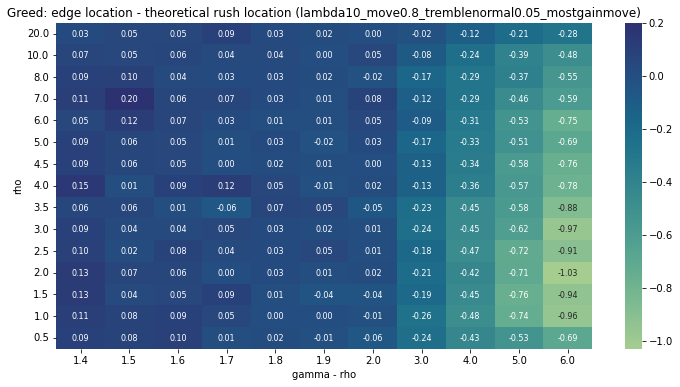

In [95]:
## edge location - theory rush location

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = df_copy['edge_location'] - df_copy['theory_rush_location']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_minus_rush', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: edge location - theoretical rush location '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'greed_edge_minus_rush.png', bbox_inches='tight')
plt.show()

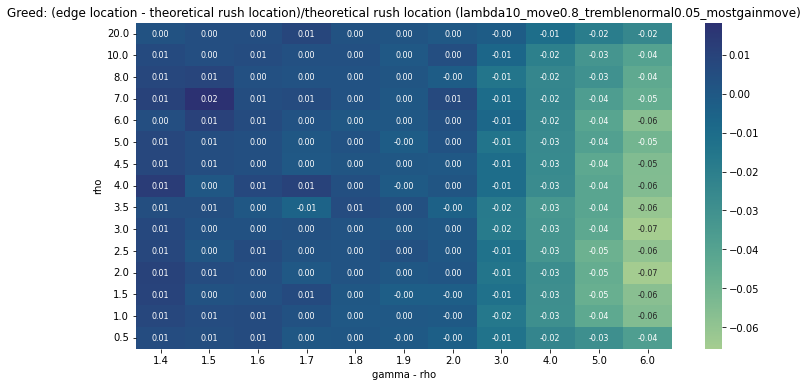

In [96]:
## (edge location - theory rush location) / theory rush location

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['edge_minus_rush'] = (df_copy['edge_location'] - df_copy['theory_rush_location'])/df_copy['theory_rush_location']
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='edge_minus_rush', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='crest')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: (edge location - theoretical rush location)/theoretical rush location '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'greed_edge_minus_rush_percentage.png', bbox_inches='tight')
plt.show()

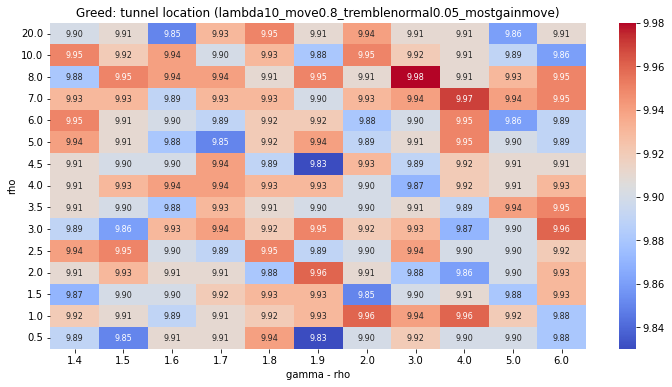

In [97]:

df_copy = df.copy()
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_copy, values='tunnel_location', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('Greed: tunnel location '+ '(lambda' + lam + '_move'+move+'_tremble'+trembling+'_mostgainmove)')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.savefig(main_folder+'greed_tunnel_location.png', bbox_inches='tight')
plt.show()